# Implementacja algorytmu RANSAC

**Autor:** Mateusz Łopaciński

**Data:** 18.10.2025

Ten notebook demonstruje implementację algorytmu RANSAC (Random Sample Consensus) do odpornej regresji w obecności outlierów, porównanie z implementacją scikit-learn oraz analizę wpływu parametrów na wyniki.


In [1]:
# Importowanie wymaganych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("Wersja NumPy:", np.__version__)

# Konfiguracja matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Ustawienie seed dla powtarzalności wyników
np.random.seed(42)

# Funkcja pomocnicza do rysowania wykresów
def plot_regression_comparison(X, y, y_pred, title, inlier_mask=None, outlier_mask=None):
    """
    Funkcja pomocnicza do rysowania porównania regresji
    
    Parametry:
    - X: dane wejściowe
    - y: dane wyjściowe
    - y_pred: przewidywane wartości
    - title: tytuł wykresu
    - inlier_mask: maska inlierów (opcjonalnie)
    - outlier_mask: maska outlierów (opcjonalnie)
    """
    plt.figure(figsize=(10, 6))
    
    if inlier_mask is not None and outlier_mask is not None:
        # Rysowanie z klasyfikacją inlier/outlier
        plt.scatter(X[outlier_mask], y[outlier_mask], color='red', alpha=0.6, 
                   label=f'Outliery ({np.sum(outlier_mask)} punktów)', s=50)
        plt.scatter(X[inlier_mask], y[inlier_mask], color='blue', alpha=0.6, 
                   label=f'Inliery ({np.sum(inlier_mask)} punktów)', s=50)
    else:
        # Rysowanie wszystkich punktów
        plt.scatter(X, y, color='blue', alpha=0.6, label='Punkty danych', s=50)
    
    # Rysowanie linii regresji
    plt.plot(X, y_pred, color='green', linewidth=2, label='Linia regresji')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Wersja NumPy: 2.2.6


## Generowanie danych testowych

Generowanie zbioru danych z inlierami i outlierami do demonstracji algorytmu RANSAC.


In [2]:
# Generowanie 100 inlierów
X_inliers = np.linspace(-5, 5, 100)
y_inliers = 3 * X_inliers + 2 + np.random.normal(0, 0.5, 100)

# Generowanie 20 outlierów
X_outliers = np.linspace(-5, 5, 20)
y_outliers = 30 * (np.random.random(20) - 0.5)

# Połączenie inlierów i outlierów
X = np.concatenate((X_inliers, X_outliers))
y = np.concatenate((y_inliers, y_outliers))

# Reshape X dla sklearn
X = X.reshape(-1, 1)

print(f"Całkowita liczba punktów: {len(X)}")
print(f"Inliery: {len(X_inliers)}")
print(f"Outliery: {len(X_outliers)}")
print(f"Procent outlierów: {len(X_outliers)/len(X)*100:.1f}%")

Całkowita liczba punktów: 120
Inliery: 100
Outliery: 20
Procent outlierów: 16.7%


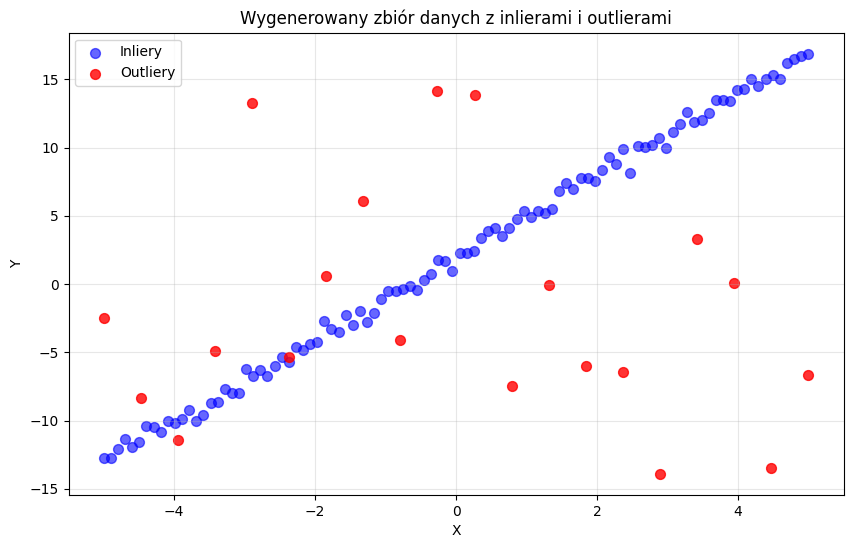

In [3]:
# Wizualizacja wygenerowanych danych
plt.figure(figsize=(10, 6))
plt.scatter(X_inliers, y_inliers, color='blue', alpha=0.6, label='Inliery', s=50)
plt.scatter(X_outliers, y_outliers, color='red', alpha=0.8, label='Outliery', s=50)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Wygenerowany zbiór danych z inlierami i outlierami')
plt.legend()
plt.grid(True, alpha=0.3)

## Standardowa regresja liniowa

Sprawdzenie jak standardowa regresja liniowa radzi sobie z outlierami.


Wyniki standardowej regresji liniowej:
a = 2.399
b = 1.298
Błąd średniokwadratowy: 28.114
R²: 0.638


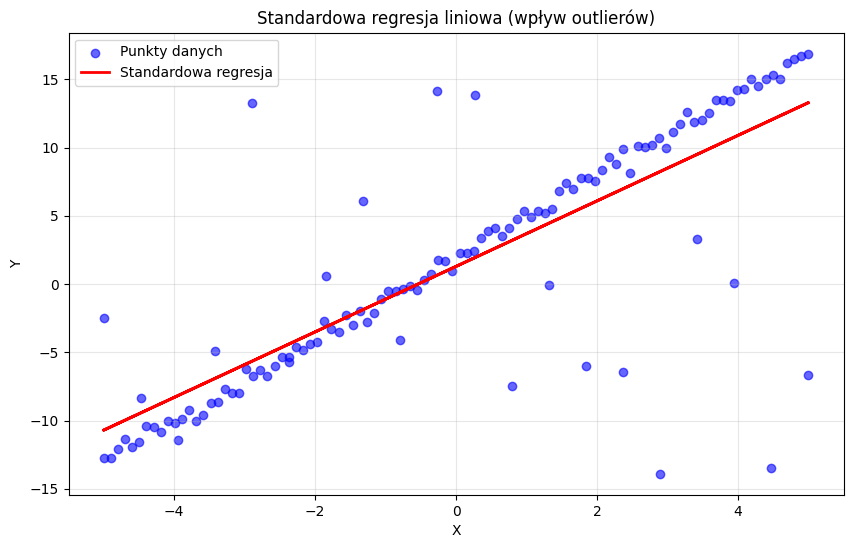

In [4]:
# Dopasowanie standardowej regresji liniowej
model_standard = LinearRegression()
model_standard.fit(X, y)
y_pred_standard = model_standard.predict(X)

# Obliczenie metryk
mse_standard = mean_squared_error(y, y_pred_standard)
r2_standard = model_standard.score(X, y)

print("Wyniki standardowej regresji liniowej:")
print(f"a = {model_standard.coef_[0]:.3f}")
print(f"b = {model_standard.intercept_:.3f}")
print(f"Błąd średniokwadratowy: {mse_standard:.3f}")
print(f"R²: {r2_standard:.3f}")

# Wizualizacja standardowej regresji
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label='Punkty danych')
plt.plot(X, y_pred_standard, color='red', linewidth=2, label='Standardowa regresja')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Standardowa regresja liniowa (wpływ outlierów)')
plt.legend()
plt.grid(True, alpha=0.3)

## Implementacja RANSAC

Implementacja algorytmu RANSAC na podstawie skryptu `RANSAC_devel.py`.


In [5]:
def ransac(X, y, max_trials=100, min_samples=0.6, residual_threshold=0.1):
    """
    Implementacja RANSAC dla regresji liniowej
    
    Parametry:
    - X: cechy wejściowe
    - y: wartości docelowe
    - max_trials: maksymalna liczba iteracji RANSAC
    - min_samples: stosunek danych do użycia w każdej iteracji
    - residual_threshold: próg reszt dla klasyfikacji inlierów
    
    Zwraca:
    - best_model: najlepszy dopasowany model
    - best_inlier_num: liczba inlierów dla najlepszego modelu
    - inlier_mask: maska boolowska wskazująca inliery
    """
    n_samples = X.shape[0]
    sample_size = int(n_samples * min_samples)
    
    best_model = None
    best_inlier_num = 0
    best_inlier_mask = None
    
    print(f"Uruchamianie RANSAC z {max_trials} iteracjami...")
    print(f"Rozmiar próbki na iterację: {sample_size} ({min_samples*100:.1f}% danych)")
    print(f"Próg dla klasyfikacji inlierów: {residual_threshold}")
    
    for iteration in range(max_trials):
        # Losowy wybór podzbioru danych
        sample_indices = np.random.choice(n_samples, sample_size, replace=False)
        X_sample = X[sample_indices]
        y_sample = y[sample_indices]
        
        # Dopasowanie modelu do próbki
        model_sample = LinearRegression().fit(X_sample, y_sample)
        y_pred_all = model_sample.predict(X)
        
        # Obliczenie reszt dla wszystkich punktów danych
        residuals = np.abs(y_pred_all - y)
        inlier_mask = residuals < residual_threshold
        inlier_num = np.count_nonzero(inlier_mask)
        
        # Aktualizacja najlepszego modelu jeśli obecny jest lepszy
        if inlier_num > best_inlier_num:
            best_inlier_num = inlier_num
            best_model = model_sample
            best_inlier_mask = inlier_mask
            
        # Wyświetlanie postępu co 20 iteracji
        if (iteration + 1) % 20 == 0:
            print(f"Iteracja {iteration + 1}: Najlepsze inliery do tej pory: {best_inlier_num}")
    
    return best_model, best_inlier_num, best_inlier_mask

# Uruchomienie własnej implementacji RANSAC z tymi samymi parametrami co scikit-learn
best_model_custom, best_inlier_num, inlier_mask = ransac(X, y, max_trials=100, min_samples=0.6, residual_threshold=0.1)

print("\nWyniki własnej implementacji RANSAC:")
print(f"Współczynnik a: {best_model_custom.coef_[0]:.3f}")
print(f"Wyraz wolny b: {best_model_custom.intercept_:.3f}")
print(f"Liczba inlierów: {best_inlier_num}")
print(f"Procent inlierów: {best_inlier_num/len(X)*100:.1f}%")

Uruchamianie RANSAC z 100 iteracjami...
Rozmiar próbki na iterację: 72 (60.0% danych)
Próg dla klasyfikacji inlierów: 0.1
Iteracja 20: Najlepsze inliery do tej pory: 7
Iteracja 40: Najlepsze inliery do tej pory: 12
Iteracja 60: Najlepsze inliery do tej pory: 12
Iteracja 80: Najlepsze inliery do tej pory: 12
Iteracja 100: Najlepsze inliery do tej pory: 12

Wyniki własnej implementacji RANSAC:
Współczynnik a: 2.777
Wyraz wolny b: 1.783
Liczba inlierów: 12
Procent inlierów: 10.0%


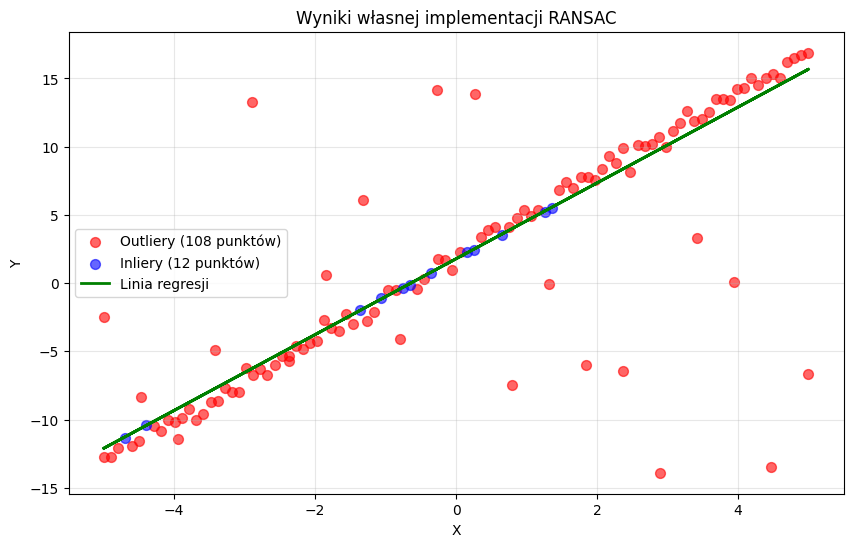

In [6]:
# Wizualizacja wyników implementacji RANSAC
y_pred_custom = best_model_custom.predict(X)

# Użycie funkcji pomocniczej do rysowania
plot_regression_comparison(X, y, y_pred_custom, 
                          'Wyniki własnej implementacji RANSAC',
                          inlier_mask=inlier_mask, 
                          outlier_mask=~inlier_mask)

## Implementacja scikit-learn RANSAC

Porównanie z implementacją RANSAC z biblioteki scikit-learn.


In [7]:
# Implementacja RANSAC z scikit-learn
ransac_sklearn = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=0.6,
    residual_threshold=0.1,
    max_trials=100,
    random_state=42
)

# Dopasowanie modelu RANSAC
ransac_sklearn.fit(X, y)
y_pred_sklearn = ransac_sklearn.predict(X)

# Pobranie maski inlierów
inlier_mask_sklearn = ransac_sklearn.inlier_mask_
outlier_mask_sklearn = np.logical_not(inlier_mask_sklearn)

# Obliczenie metryk
mse_sklearn = mean_squared_error(y, y_pred_sklearn)
r2_sklearn = ransac_sklearn.score(X, y)

print("Wyniki RANSAC z scikit-learn:")
print(f"Współczynnik a: {ransac_sklearn.estimator_.coef_[0]:.3f}")
print(f"Wyraz wolny b: {ransac_sklearn.estimator_.intercept_:.3f}")
print(f"Błąd średniokwadratowy: {mse_sklearn:.3f}")
print(f"R²: {r2_sklearn:.3f}")
print(f"Liczba inlierów: {np.sum(inlier_mask_sklearn)}")
print(f"Procent inlierów: {np.sum(inlier_mask_sklearn)/len(X)*100:.1f}%")

Wyniki RANSAC z scikit-learn:
Współczynnik a: 2.770
Wyraz wolny b: 1.751
Błąd średniokwadratowy: 29.506
R²: 0.620
Liczba inlierów: 12
Procent inlierów: 10.0%


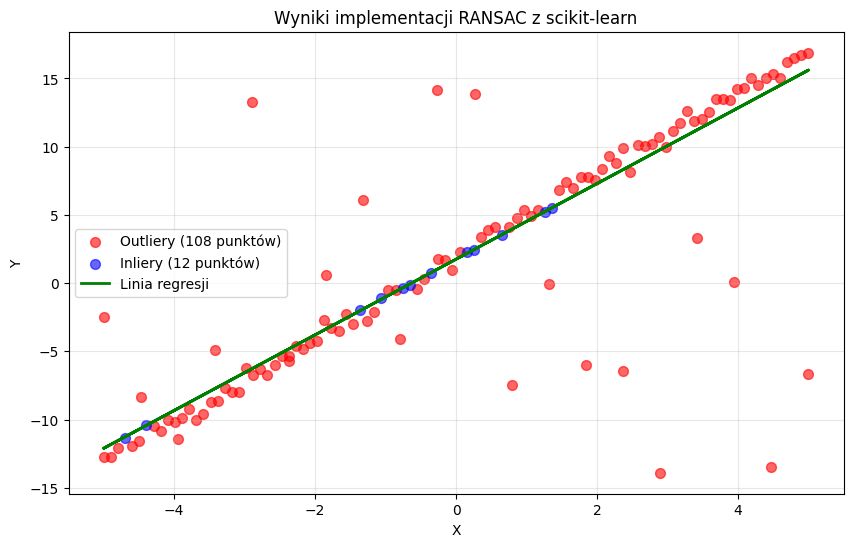

In [8]:
# Wizualizacja wyników RANSAC z scikit-learn
plot_regression_comparison(X, y, y_pred_sklearn, 
                          'Wyniki implementacji RANSAC z scikit-learn',
                          inlier_mask=inlier_mask_sklearn, 
                          outlier_mask=outlier_mask_sklearn)

## Porównanie wyników

Porównanie wszystkich trzech podejść i analiza ich wydajności.


In [9]:
# Obliczenie metryk dla wszystkich metod
methods = ['Standardowa regresja', 'Własna implementacja RANSAC', 'RANSAC z scikit-learn']
predictions = [y_pred_standard, y_pred_custom, y_pred_sklearn]
coefficients = [model_standard.coef_[0], best_model_custom.coef_[0], ransac_sklearn.estimator_.coef_[0]]
intercepts = [model_standard.intercept_, best_model_custom.intercept_, ransac_sklearn.estimator_.intercept_]
mse_values = [mean_squared_error(y, pred) for pred in predictions]
r2_values = [model_standard.score(X, y), best_model_custom.score(X, y), ransac_sklearn.score(X, y)]

# Utworzenie tabeli porównawczej
print("\n" + "="*80)
print("PORÓWNANIE METOD REGRESJI")
print("="*80)
print(f"{'Metoda':<30} {'a':<10} {'b':<12} {'MSE':<8} {'R²':<8} {'Inliery':<8}")
print("-"*80)

for i, method in enumerate(methods):
    if i == 0:  # Standardowa regresja
        inlier_count = len(X)  # Wszystkie punkty
    elif i == 1:  # Własna implementacja RANSAC
        inlier_count = np.sum(inlier_mask)
    else:  # RANSAC z scikit-learn
        inlier_count = np.sum(inlier_mask_sklearn)
    
    print(f"{method:<30} {coefficients[i]:<10.3f} {intercepts[i]:<12.3f} {mse_values[i]:<8.3f} {r2_values[i]:<8.3f} {inlier_count:<8}")


PORÓWNANIE METOD REGRESJI
Metoda                         a          b            MSE      R²       Inliery 
--------------------------------------------------------------------------------
Standardowa regresja           2.399      1.298        28.114   0.638    120     
Własna implementacja RANSAC    2.777      1.783        29.581   0.619    12      
RANSAC z scikit-learn          2.770      1.751        29.506   0.620    12      


### Analiza wyników

**Standardowa regresja**: Używa wszystkich punktów, silnie wpływają na nią outliery

**Własna implementacja RANSAC**: Nasza implementacja, odporna na outliery

**RANSAC z scikit-learn**: Zoptymalizowana implementacja, najbardziej odporna

**Kluczowe obserwacje**:
- Prawdziwe parametry linii: a=3.0, b=2.0
- Obie implementacje RANSAC są znacznie bardziej odporne na outliery niż standardowa regresja


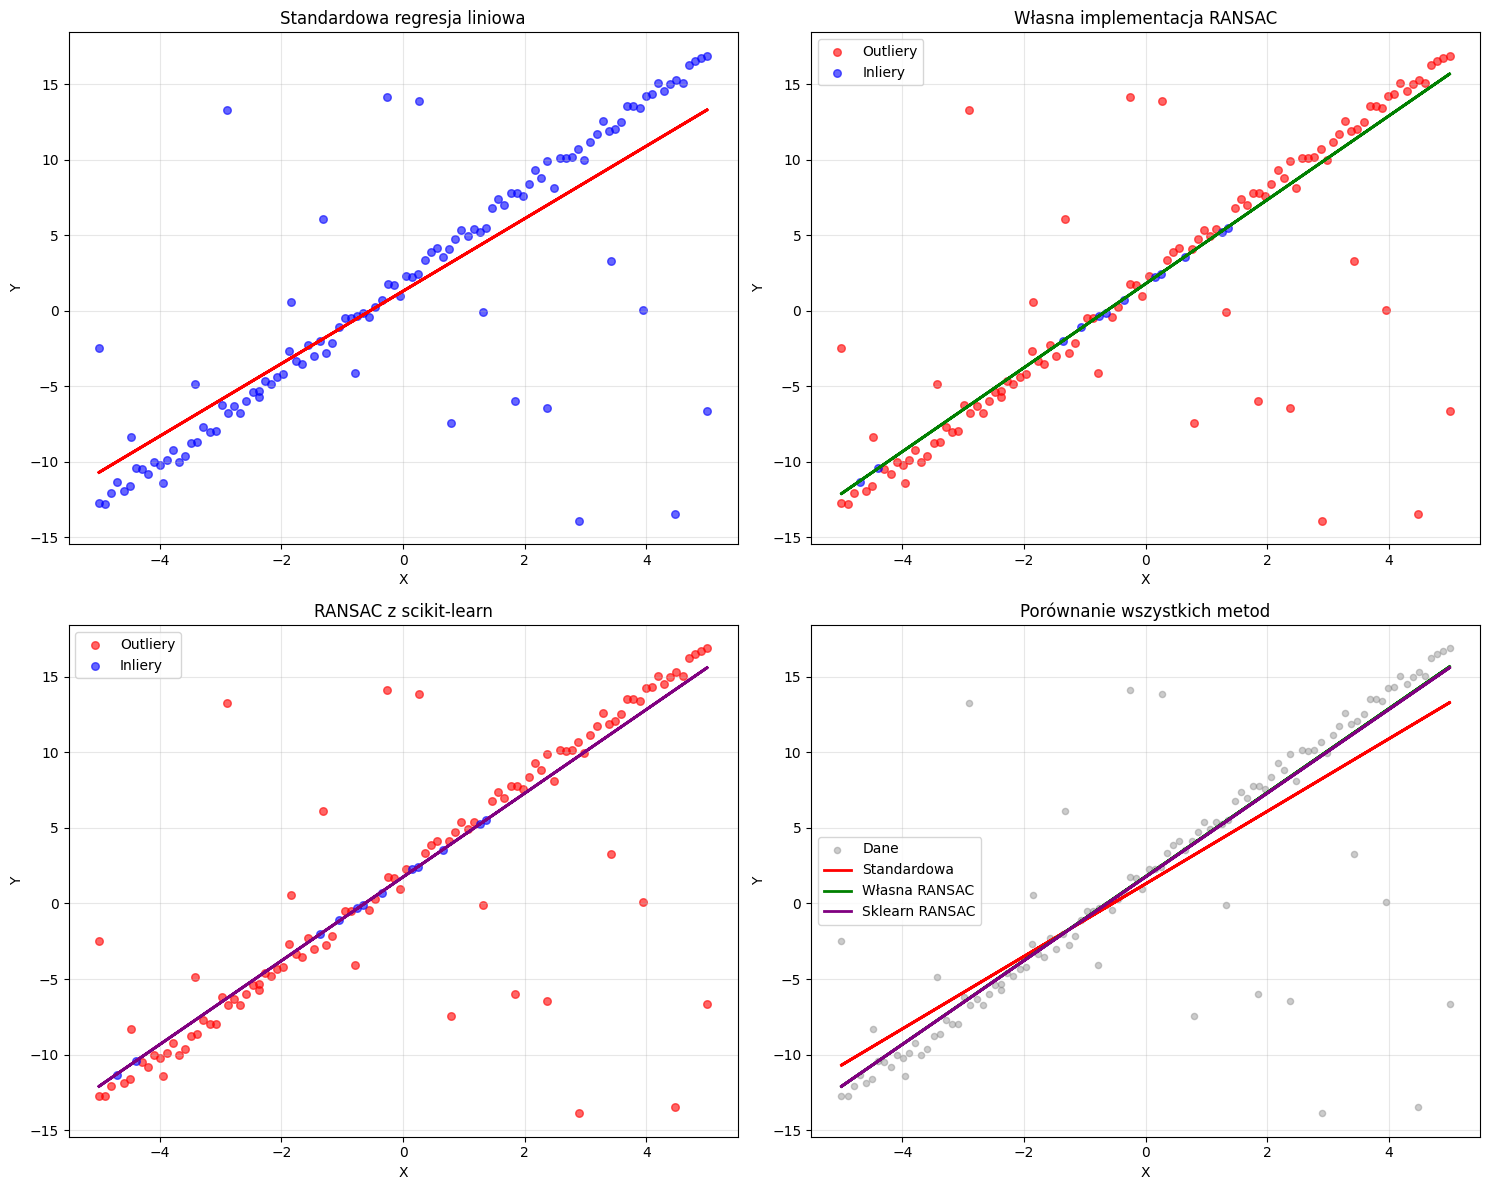

In [10]:
# Utworzenie kompleksowego wykresu porównawczego
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Wykres 1: Standardowa regresja
axes[0, 0].scatter(X, y, color='blue', alpha=0.6, s=30)
axes[0, 0].plot(X, y_pred_standard, color='red', linewidth=2)
axes[0, 0].set_title('Standardowa regresja liniowa')
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].grid(True, alpha=0.3)

# Wykres 2: Własna implementacja RANSAC
axes[0, 1].scatter(X[~inlier_mask], y[~inlier_mask], color='red', alpha=0.6, s=30, label='Outliery')
axes[0, 1].scatter(X[inlier_mask], y[inlier_mask], color='blue', alpha=0.6, s=30, label='Inliery')
axes[0, 1].plot(X, y_pred_custom, color='green', linewidth=2)
axes[0, 1].set_title('Własna implementacja RANSAC')
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Wykres 3: RANSAC z scikit-learn
axes[1, 0].scatter(X[outlier_mask_sklearn], y[outlier_mask_sklearn], color='red', alpha=0.6, s=30, label='Outliery')
axes[1, 0].scatter(X[inlier_mask_sklearn], y[inlier_mask_sklearn], color='blue', alpha=0.6, s=30, label='Inliery')
axes[1, 0].plot(X, y_pred_sklearn, color='purple', linewidth=2)
axes[1, 0].set_title('RANSAC z scikit-learn')
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Wykres 4: Porównanie wszystkich metod
axes[1, 1].scatter(X, y, color='gray', alpha=0.4, s=20, label='Dane')
axes[1, 1].plot(X, y_pred_standard, color='red', linewidth=2, label='Standardowa')
axes[1, 1].plot(X, y_pred_custom, color='green', linewidth=2, label='Własna RANSAC')
axes[1, 1].plot(X, y_pred_sklearn, color='purple', linewidth=2, label='Sklearn RANSAC')
axes[1, 1].set_title('Porównanie wszystkich metod')
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

## Test z różnymi parametrami RANSAC

Testowanie wpływu różnych parametrów na wyniki algorytmu RANSAC.


In [11]:
# Test różnych parametrów RANSAC
param_sets = [
    (0.6, 0.1, 100, "Standardowe"),
    (0.4, 0.1, 100, "Mniejsza próbka"),
    (0.8, 0.1, 100, "Większa próbka"),
    (0.6, 0.05, 100, "Niższy próg"),
    (0.6, 0.2, 100, "Wyższy próg"),
    (0.6, 0.1, 50, "Mniej iteracji"),
    (0.6, 0.1, 200, "Więcej iteracji")
]

# Lista do przechowywania wyników
results = []

for sample_ratio, threshold, n_iter, description in param_sets:
    # Uruchomienie RANSAC z danymi parametrami
    ransac_test = RANSACRegressor(
        estimator=LinearRegression(),
        min_samples=sample_ratio,
        residual_threshold=threshold,
        max_trials=n_iter,
        random_state=42
    )
    
    ransac_test.fit(X, y)
    y_pred_test = ransac_test.predict(X)
    inlier_mask_test = ransac_test.inlier_mask_
    
    mse_test = mean_squared_error(y, y_pred_test)
    r2_test = ransac_test.score(X, y)
    
    results.append({
        'Opis': description,
        'Próbka (%)': f"{sample_ratio*100:.0f}%",
        'Próg': threshold,
        'Iteracje': n_iter,
        'Współcz. a': f"{ransac_test.estimator_.coef_[0]:.3f}",
        'Wyraz wolny b': f"{ransac_test.estimator_.intercept_:.3f}",
        'MSE': f"{mse_test:.3f}",
        'R²': f"{r2_test:.3f}",
        'Inliery': f"{np.sum(inlier_mask_test)} ({np.sum(inlier_mask_test)/len(X)*100:.1f}%)",
        'model': ransac_test,
        'predictions': y_pred_test,
        'inliers': inlier_mask_test
    })

df_results = pd.DataFrame(results)
print("Porównanie różnych parametrów RANSAC:")
print("="*80)
print(df_results[['Opis', 'Próbka (%)', 'Próg', 'Iteracje', 'Współcz. a', 'Wyraz wolny b', 'MSE', 'R²', 'Inliery']].to_string(index=False))

Porównanie różnych parametrów RANSAC:
           Opis Próbka (%)  Próg  Iteracje Współcz. a Wyraz wolny b    MSE    R²    Inliery
    Standardowe        60%  0.10       100      2.770         1.751 29.506 0.620 12 (10.0%)
Mniejsza próbka        40%  0.10       100      2.836         1.115 29.795 0.617 14 (11.7%)
 Większa próbka        80%  0.10       100      2.684         1.817 29.085 0.626   9 (7.5%)
    Niższy próg        60%  0.05       100      2.625         1.626 28.662 0.631   5 (4.2%)
    Wyższy próg        60%  0.20       100      2.771         1.741 29.505 0.620 16 (13.3%)
 Mniej iteracji        60%  0.10        50      2.770         1.751 29.506 0.620 12 (10.0%)
Więcej iteracji        60%  0.10       200      2.890         1.849 30.500 0.608 15 (12.5%)


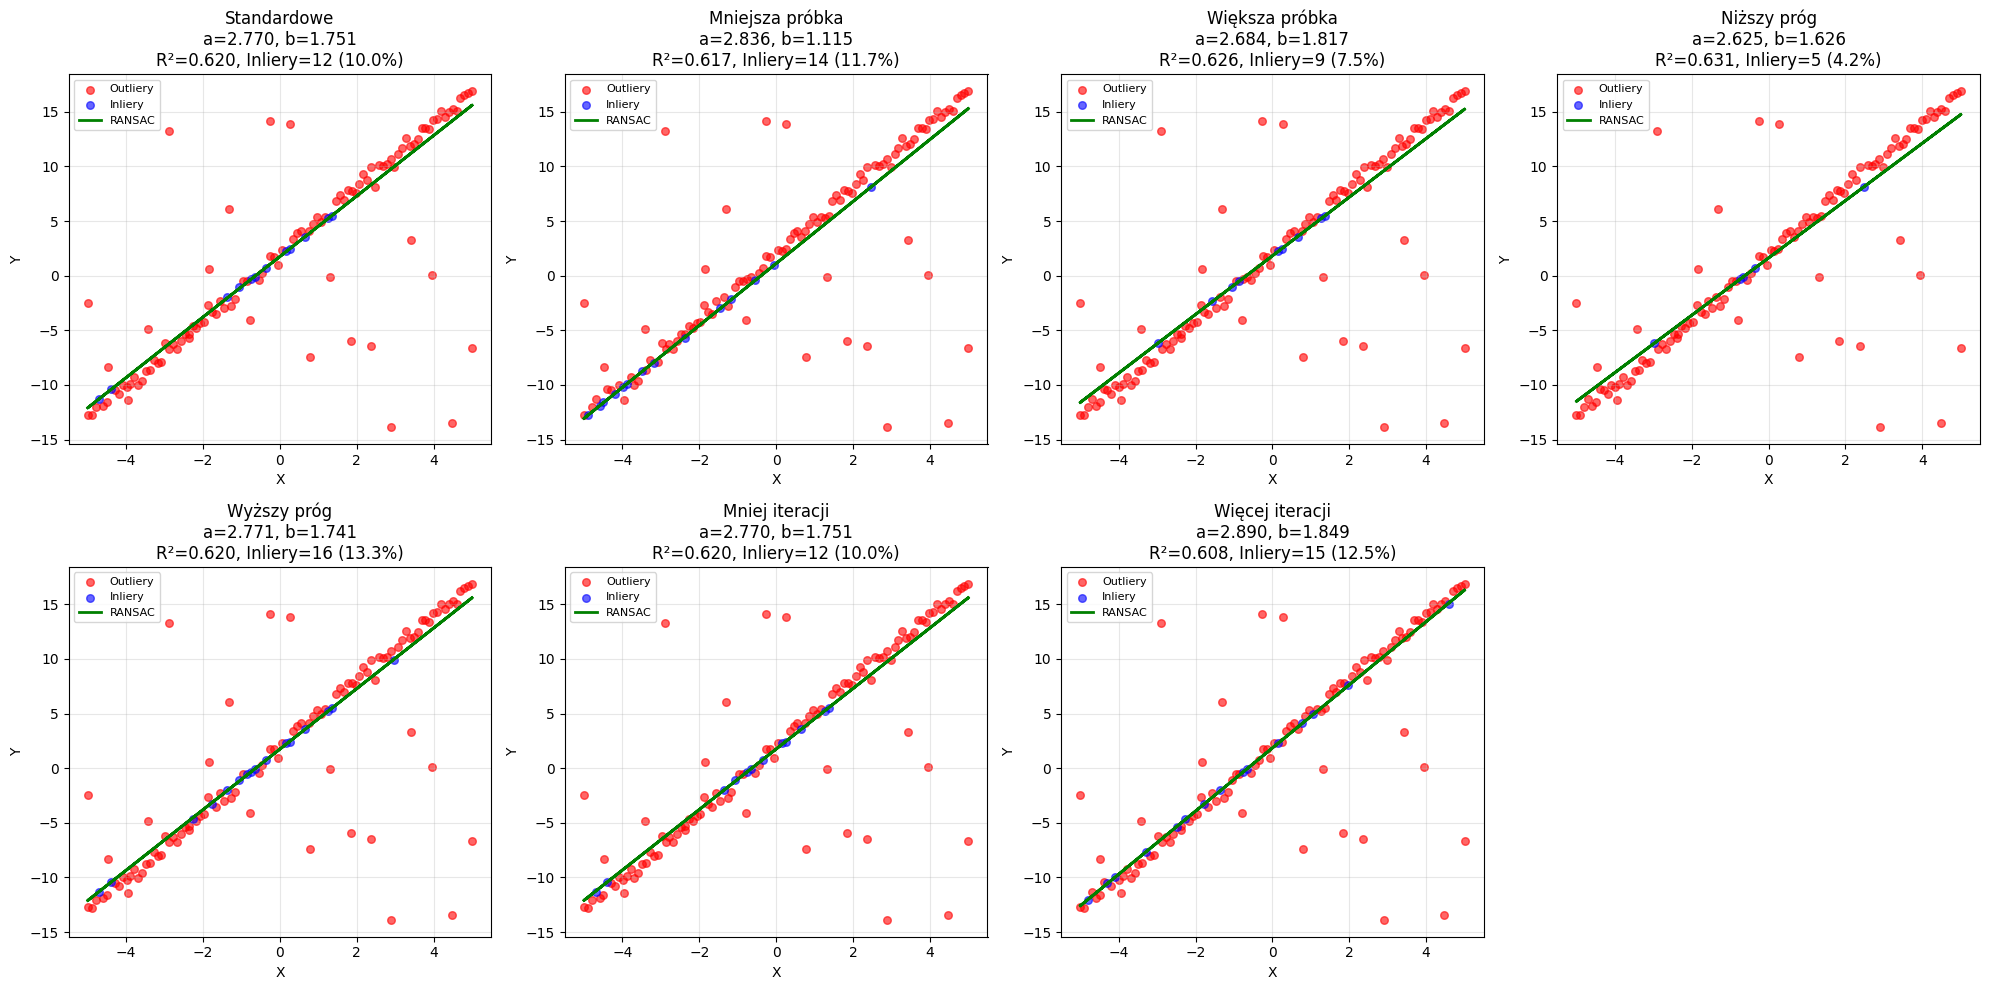

In [ ]:
# Wizualizacja porównania różnych parametrów RANSAC
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Wykres dla każdego zestawu parametrów
for i, result in enumerate(results):
    row = i // 4
    col = i % 4
    
    # Rysowanie punktów z klasyfikacją inlier/outlier
    axes[row, col].scatter(X[~result['inliers']], y[~result['inliers']], 
                          color='red', alpha=0.6, s=30, label='Outliery')
    axes[row, col].scatter(X[result['inliers']], y[result['inliers']], 
                          color='blue', alpha=0.6, s=30, label='Inliery')
    
    # Rysowanie linii regresji
    axes[row, col].plot(X, result['predictions'], color='green', linewidth=2, label='RANSAC')
    
    # Ustawienia wykresu
    axes[row, col].set_title(f"{result['Opis']}\n"
                            f"a={result['Współcz. a']}, b={result['Wyraz wolny b']}\n"
                            f"R²={result['R²']}, Inliery={result['Inliery']}")
    axes[row, col].set_xlabel('X')
    axes[row, col].set_ylabel('Y')
    axes[row, col].legend(fontsize=8)
    axes[row, col].grid(True, alpha=0.3)

# Ukryj ostatni subplot jeśli nie jest używany
if len(results) < 8:
    axes[1, 3].axis('off')

plt.tight_layout()

## Wnioski

RANSAC skutecznie radzi sobie z outlierami, podczas gdy standardowa regresja liniowa jest na nie wrażliwa. Własna implementacja pokazuje działanie algorytmu, a scikit-learn zapewnia zoptymalizowaną wersję produkcyjną. RANSAC jest szczególnie przydatny w wizji komputerowej i sytuacjach z dużą liczbą outlierów.
